In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
from io import StringIO
import requests
import json
import plotly.express as px
import ipywidgets as widgets
from datetime import datetime
import imageio
import os

Populating the interactive namespace from numpy and matplotlib


In [48]:
def get_geojson_file(filename):
    with open('geojson/'+filename) as json_file:
        data = json.load(json_file)
        return data

#URL_province_geojson="https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson"
filename_municipalities = "limits_IT_municipalities.geojson"

def get_geojson_file(filename):
    with open('geojson/'+filename) as json_file:
        data = json.load(json_file)
        return data


geojson_province = get_geojson_file(filename_municipalities)
#geojson_province = getGeoJson(URL_province_geojson)

len([g['properties']['prov_acr'] for g in geojson_province['features']])

bz_features = [g for g in geojson_province['features'] if g['properties']['prov_acr']=='BZ']
bz_geojson = geojson_province['features'] = bz_features


# Get COVID data

In [71]:

today = datetime(2020, 3, 27).strftime("%d-%m-%Y")

tested={
    datetime(2020, 3, 26).strftime("%d-%m-%Y") : "http://www.provinz.bz.it/news/de/news.asp?news_action=300&news_image_id=1061992",
    datetime(2020, 3, 27).strftime("%d-%m-%Y") : "http://www.provinz.bz.it/news/de/news.asp?news_action=300&news_image_id=1062210",
}
quarantaene = {
    datetime(2020, 3, 26).strftime("%d-%m-%Y") : "http://www.provinz.bz.it/news/de/news.asp?news_action=300&news_image_id=1061998",
    datetime(2020, 3, 27).strftime("%d-%m-%Y") : "http://www.provinz.bz.it/news/de/news.asp?news_action=300&news_image_id=1062211",
}

def get_excel_url(url, header=0):
    s=requests.get(url)
    #print(s.content)
    return pd.read_excel(s.content, header=header)
  
# get quarantined
quaran = get_excel_url(quarantaene[today], header=2)
total_quarantined = quaran.loc[quaran['Cod Istat'] == 'Totale complessivo', 'Numero casi al '+today].values[0]

#get test positive and clean
tested = get_excel_url(tested[today], header=2)
total_positives = tested.loc[tested['Comune di residenza'] == 'Totale complessivo','Totali al '+ today].values[0]

tested = tested[tested['Codice Istat Comune'].notna()] # remove lines with na
tested = tested[tested['Struttura di provenienza richiesta'].isna()] # only take total

# put together
tested = pd.DataFrame({
    "Cod Istat": tested['Codice Istat Comune'].astype(int),
    "positives": tested['Totali al '+ today].astype(int),
})
# tested.set_index(['Cod Istat'], inplace=True)
#quaran.set_index(['Cod Istat'], inplace=True)
quaran = quaran.rename(columns={"Numero casi al "+today: "quarantined"}) # error in file for 26-03-2020 =>26-03-2025
df = pd.concat([quaran, tested]).groupby('Cod Istat').last().fillna(value=0)
# add total for csv
df.at["Totale complessivo","positives"] = total_positives

# write clean data to file (including total)
df.to_csv("output/clean_%s.csv" % today,decimal=",", sep=";")

sum_quarantined = df["quarantined"].sum()
sum_positives = df["positives"].sum()

print("positives: sum %s, total %s"% (int(sum_positives-total_positives), total_positives))
print("quarantined: sum %s, total %s"% (int(sum_quarantined-total_quarantined), total_quarantined))


positives: sum 917, total 1003
quarantined: sum 3485, total 3669


# plot map

In [50]:

def bz_map(file, title, color_field = "quarantined", color_scale = "Red", max_value=None):
    total_positives = file.loc["Totale complessivo", 'positives']
    total_quarantined = file.loc["Totale complessivo", 'quarantined']
    
    # clean for mapping
    file = file.drop("Totale complessivo") # remove total row
    file = file.reset_index() # indexes dont work well (dunno why)

#     sum_quarantined = file["quarantined"].sum()
#     sum_positves = file["positives"].sum()
#     print("positives: sum %s, total %s"% (int(sum_positives), total_positives))
#     print("quarantined: sum %s, total %s"% (int(sum_quarantined), total_quarantined))

    numbers = "Total Quarantined: %s, COVID Positives: %s" % (int(total_quarantined), int(total_positives))
    #print(number)
    if not max_value:
        max_value = file[color_field].max()

    fig = px.choropleth(file, geojson=geojson_province, 
                        color=color_field,
                        range_color=(0, max_value),
                        color_continuous_scale=["white", color_scale],
                        locations="Cod Istat", 
                        featureidkey="properties.com_istat_code_num",
                        projection="mercator",
                        hover_data=["Wohngemeinde", "positives", "quarantined"],
                        labels={color_field:'Total '+color_field}
                       )
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(
        margin={"r":0,"t":30,"l":0,"b":0},
        title={
        'text': title + numbers,
        'y':0.93,
        'x':0.1},
        title_font_size=20,
        
        #geo_scope='europe', # limite map scope to Europe
        annotations = [dict(
            x=0.55,
            y=0.02,
            xref='paper',
            yref='paper',
            text='Source: <a href="http://www.provinz.bz.it/>http://www.provinz.bz.it</a><br>©Copyright Annette Werth',
            showarrow = False
    )]
   )
    return fig

title = today + ": COVID-positive Südtiroler<br>"
fig = bz_map(df, title, color_field="positives", color_scale="Red" )
fig.show()

In [51]:
title = today + ": COVID-positive Südtiroler<br>"
fig = bz_map(df, title, color_field="positives", color_scale="Red" )
fig.show()

In [52]:
title = today + ": Südtiroler in häuslicher Isolation<br>"
fig = bz_map(df, title, color_field="quarantined", color_scale="Blue" )
fig.show()

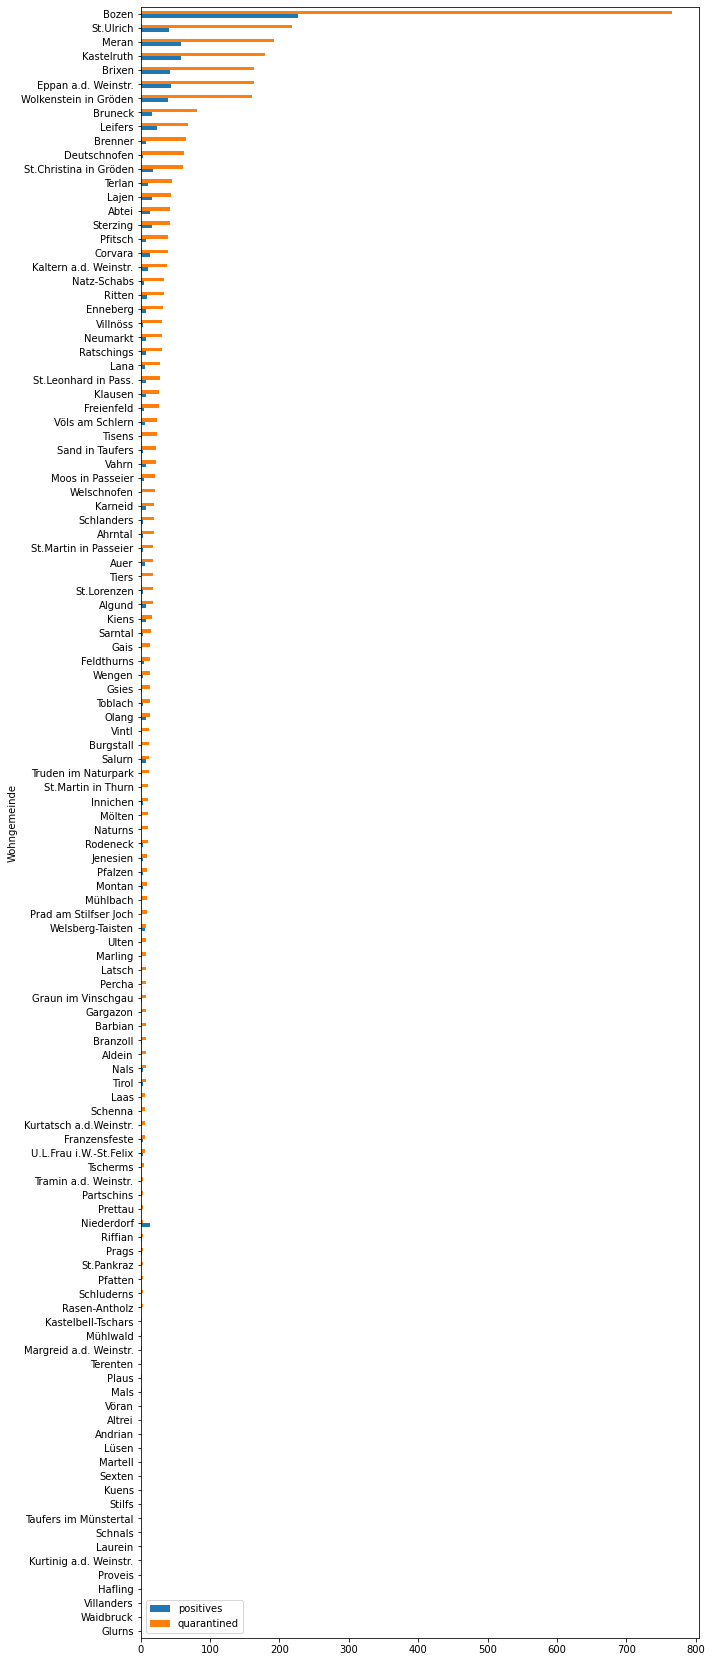

In [68]:
#print(df.tail())
start_date = datetime(2020, 3, 20)
end_date = datetime(2020, 3, 27)
possible_dates = pd.date_range(start=start_date, end=end_date, freq='D')

total_df = df.iloc[-1]
total_df

com_df = df.drop(df.tail(1).index) # drop last n rows
com_df = com_df.reset_index() # indexes dont work well (dunno why)
com_df = com_df.sort_values(by=['quarantined'])

df.columns
# df.iloc[-1].plot(kind='bar');
com_df.plot.barh( x='Wohngemeinde', y=[df.columns[8],df.columns[6]],figsize=(10,30))